In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report 

In [2]:
models_name = ["resnet", "alexnet", "vgg", "squeezenet", "inception"]

In [3]:
import os
data_dir = os.getcwd() + "/hymenoptera_data/"
print(data_dir)

resnet = models_name[0]

num_classes = 2

batch_size = 8

num_epochs = 5

feature_extract = True

/home/quyen/Project/image-captioning/model/hymenoptera_data/


In [4]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(num_epochs):
        # training phase
        loss_train = 0.0
        
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        # save training loss for this epoch
        train_loss_history.append(loss_train/len(dataloaders['train']))
        
        # validation phase
        correct = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds += preds.tolist()
                all_labels += labels.tolist()
                c = (preds == labels).squeeze()
                correct += c.sum()
                
        if epoch % 1 == 0:
            print("Epoch: {} Training loss: {}, Val accuracy {}".format(
                epoch, 
                loss_train/len(dataloaders['train']), 
                correct/len(dataloaders['val']))
                )
        
        # Print classification report for validation set
        print("Classification Report for Epoch {}:".format(epoch))
        print(classification_report(all_labels, all_preds))
    
    # Plotting training loss
    plt.figure()
    plt.plot(train_loss_history, label='Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

img when it is not transform : (512, 768, 3)
img when it has transformed : torch.Size([3, 224, 224])
<class 'torch.Tensor'>
tensor([0.3450, 0.5780, 0.8531])
tensor([0.0784, 0.1086, 0.1869])


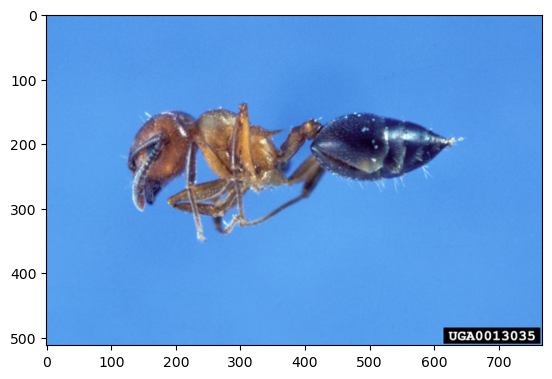

In [5]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Read the image using cv2
img = cv2.imread("/home/quyen/Project/image-captioning/model/datasets/hymenoptera_data/train/ants/0013035.jpg")
# Convert the image from BGR to RGB format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Convert the image to PIL format
img_pil = Image.fromarray(img)
plt.imshow(img_pil)

print(f"img when it is not transform : {img.shape}")

# Apply the transformation
img_tensor = transform(img_pil)
print(f"img when it has transformed : {img_tensor.shape}")

print(type(img_tensor))

print(img_tensor.view(3, -1).mean(dim=1))
print(img_tensor.view(3, -1).std(dim=1))


In [6]:
# load data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create training and validation datasets
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val']),
}

print(f"size of train set: {len(image_datasets['train'])}")
print(f"size of val set: {len(image_datasets['val'])}")

# Create training and validation dataloaders
data_loaders = {
    'train': DataLoader(image_datasets['train'], shuffle=True, batch_size=batch_size),
    'val': DataLoader(image_datasets['val'], shuffle=False, batch_size=batch_size),
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

size of train set: 244
size of val set: 153


/home/quyen/miniconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


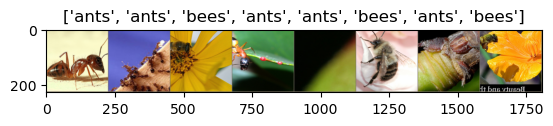

In [7]:
import torchvision

# visualize a few images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) # convert tensor to numpy and change (C, H, W) to (H, W, C)
    mean = np.array([0.485, 0.456, 0.406]) # mean of ImageNet dataset
    std = np.array([0.229, 0.224, 0.225]) # std of ImageNet dataset
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    
# Get a batch of training data
inputs, classes = next(iter(data_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[image_datasets['train'].classes[x] for x in classes])

In [8]:
# load a pretrained model and reset final fully connected layer
model_ft = models.resnet18(weights='IMAGENET1K_V1') # load a pretrained model
num_ftrs = model_ft.fc.in_features # get the number of input features of the last layer
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


Epoch: 0 Training loss: 0.49239191701335294, Val accuracy 4.25
Classification Report for Epoch 0:
              precision    recall  f1-score   support

           0       0.54      0.21      0.31        70
           1       0.56      0.84      0.67        83

    accuracy                           0.56       153
   macro avg       0.55      0.53      0.49       153
weighted avg       0.55      0.56      0.51       153

Epoch: 1 Training loss: 0.31313633017482295, Val accuracy 4.150000095367432
Classification Report for Epoch 1:
              precision    recall  f1-score   support

           0       0.50      0.49      0.49        70
           1       0.58      0.59      0.58        83

    accuracy                           0.54       153
   macro avg       0.54      0.54      0.54       153
weighted avg       0.54      0.54      0.54       153

Epoch: 2 Training loss: 0.35421249060140503, Val accuracy 4.0
Classification Report for Epoch 2:
              precision    recall  f1-sc

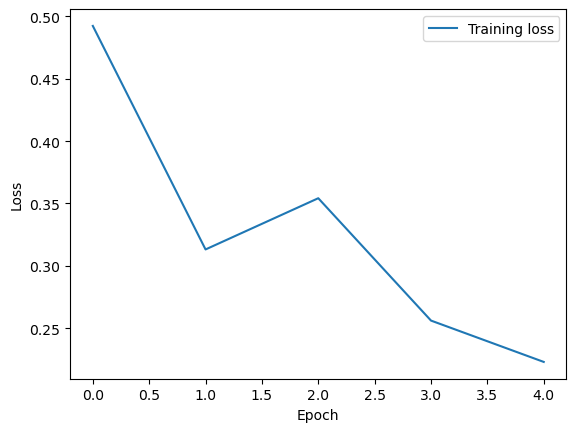

In [9]:
model_ft = train_model(model_ft, data_loaders, criterion, optimizer_ft, num_epochs=num_epochs)

In [10]:
# visualizing the model predictions
def visualize_model():
    pass